## Importando bibliotecas e base

In [2]:
from warnings import filterwarnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TunedThresholdClassifierCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc, mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

from util import *
import joblib

filterwarnings('ignore')
pd.set_option('display.max_columns', None)

C:\Users\Jean\Documents\projetos\plano_saude\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_parquet("../data/processed/df.parquet")
df.head()

,Idade,Sexo,IMC,Qte_Filhos,Fumante,Região,Custo_Saude
0,19,Feminino,27.900,0,Sim,Centro,1688.492400
1,18,Masculino,33.770,1,Não,Sudeste,172.555230
2,28,Masculino,33.000,3,Não,Sudeste,444.946200
3,33,Masculino,22.705,0,Não,Norte,2198.447061
4,32,Masculino,28.880,0,Não,Norte,386.685520


## Houldout Out-Of-Sample

In [4]:
# Separando as variáveis de entrada (features) e de saída (target)
X = df.drop(columns=["Custo_Saude"])
y = df["Custo_Saude"]

In [5]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((936, 6), (402, 6))

## Dataprep e Feature Selection

In [6]:
cat_attributes = X_train.select_dtypes(include='object')
num_attributes = X_train.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])
preprocesssor = Pipeline(steps=[("preprocessor", preprocessor)])


X_train_processed = pd.DataFrame(preprocesssor.fit_transform(X_train, y_train),columns=X_train.columns)
X_test_processed = pd.DataFrame(preprocesssor.transform(X_test),columns=X_test.columns)
#X_prod_processed = pd.DataFrame(preprocessor.transform(df_test),columns=df_test.columns)

In [7]:
# Salva o pipeline na pasta models
joblib.dump(preprocesssor, '../models/preprocesssor.joblib')

['../models/preprocesssor.joblib']

## Feature Selection

In [8]:
X_train_transformed = X_train_processed

In [9]:
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train_transformed, y_train)

RandomForestRegressor(random_state=42)

Número de features selecionadas:  3


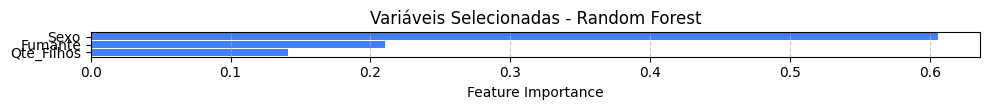

In [10]:
#Obtendo o feature importance
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

#Ordenar vars por importância
features = features.sort_values(by='Importance', ascending=False)

#Estabelecendo um ponto de corte
cutoff_maximp = 0.1

cutoff = cutoff_maximp * feature_importances.max()

# Selecionando vars acima do ponto de corte
selected_features = X.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ', len(selected_features))

#Ordenar vars por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Salva as features selecionadas na pasta models
joblib.dump(selected_features, '../models/selected_features.joblib')

['../models/selected_features.joblib']

In [12]:
selected_features

['Sexo', 'Qte_Filhos', 'Fumante']

## Testar algoritmos

In [13]:
algoritmos = [
    DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_leaf=2),
    RandomForestRegressor(random_state=0, max_depth=5, min_samples_leaf=2),
]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed[selected_features],y_train)

    # Avaliar modelo
    metricas = calculate_metrics_models_regression(nome_algoritmo,algoritmo, X_train_processed[selected_features], y_train, X_test_processed[selected_features], y_test)
    display(metricas)

,Algoritmo,Conjunto,R2,MAE,MSE,RMSE
0,DecisionTreeRegressor,Treino,0.871709,248.667765,187905.262612,433.480406
1,DecisionTreeRegressor,Teste,0.856558,275.830745,210321.468314,458.608186


,Algoritmo,Conjunto,R2,MAE,MSE,RMSE
0,RandomForestRegressor,Treino,0.880204,234.920288,175463.976595,418.884204
1,RandomForestRegressor,Teste,0.863457,261.964454,200205.588978,447.443392


## Tunagem de hiperparâmetros

In [14]:

from sklearn.model_selection import cross_val_score, KFold
import optuna
def objective(trial):
    # Espaço de busca de hiperparâmetros
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42,
    }

    model = RandomForestRegressor(**param)

    # KFold para regressão
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_train_processed, y_train, cv=cv,
        scoring='neg_mean_absolute_error', n_jobs=-1
    )

    # Retorna a média do MAE (em valor positivo para minimizar)
    return -scores.mean()

# Criação e execução do estudo
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

# Resultados
print("Melhores hiperparâmetros:", study.best_params)
print("Menor MAE:", study.best_value)

[I 2025-05-25 11:21:43,957] A new study created in memory with name: no-name-5c1c5123-4989-411a-9cba-4e20c592b3dc
[I 2025-05-25 11:21:48,159] Trial 1 finished with value: 265.8543399803265 and parameters: {'n_estimators': 130, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 1 with value: 265.8543399803265.
[I 2025-05-25 11:21:48,644] Trial 10 finished with value: 316.03802692440604 and parameters: {'n_estimators': 118, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 265.8543399803265.
[I 2025-05-25 11:21:48,921] Trial 0 finished with value: 436.31726064903626 and parameters: {'n_estimators': 431, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 1 with value: 265.8543399803265.
[I 2025-05-25 11:21:49,506] Trial 2 finished with value: 391.98371841347597 and parameters: {'n_estimators': 276, 'max_depth': 30, 'min_s

Melhores hiperparâmetros: {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None}
Menor MAE: 264.19477008418147


In [15]:
algoritmo = RandomForestRegressor(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_processed,y_train)

# Avaliar modelo
metricas = calculate_metrics_models_regression(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)

,Algoritmo,Conjunto,R2,MAE,MSE,RMSE
0,RandomForestRegressor,Treino,0.871778,246.083627,187804.294419,433.363928
1,RandomForestRegressor,Teste,0.869117,256.122270,191906.179691,438.070976


In [16]:
# Salva as features selecionadas na pasta models
joblib.dump(algoritmo, '../models/algoritmo.joblib')

['../models/algoritmo.joblib']